In [1]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img
import cvxpy as cp
from sklearn.model_selection import KFold
from itertools import product
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA
import scipy.sparse as sp
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.stats import zscore
from scipy.io import loadmat
from scipy import ndimage

In [2]:
ses = 1
sub = '04'
run = 2
num_trials = 90
trial_len = 9

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
anat_path = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
mask_base = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat'

behaviour_metric_names = ("PT", "RT", "MT", "RT+MT", "Vmax", "Pmax")
if ses == 1:
    behave_path = f"/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD0{sub}_OFF_behav_metrics.mat"
else:
    behave_path = f"/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD0{sub}_ON_behav_metrics.mat"


Loading Datasets and Masks

In [3]:
anat_img = nib.load(anat_path) 

BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

brain_mask_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
brain_mask_img = nib.load(brain_mask_path)
back_mask = brain_mask_img.get_fdata()

csf_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
csf_mask = nib.load(csf_path).get_fdata()

wm_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_1.nii.gz'
gray_mask = nib.load(wm_path).get_fdata()

Apply Masks on Bold Dataset

In [4]:
back_mask_data = back_mask > 0
csf_mask_data = csf_mask > 0
gray_mask_data = gray_mask > 0.5
mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)

keep_voxels = gray_mask_data[nonzero_mask]

bold_flat = bold_data[nonzero_mask]
masked_bold = bold_flat[keep_voxels]
masked_coords = tuple(ax[keep_voxels] for ax in nonzero_mask)

# print(f'{masked_bold.shape[0]/np.prod(bold_data.shape[:3]): .2%}% of selected voxels after masking')

# mask_volume = np.zeros(bold_img.shape[:3], dtype=np.uint8)
# mask_volume[masked_coords] = 1 

# mask_img = nib.Nifti1Image(mask_volume, bold_img.affine, bold_img.header)
# mask_img_resampled = resample_to_img(mask_img, anat_img, interpolation="nearest")
# view = plotting.view_img(
#     mask_img_resampled,
#     bg_img=anat_img,
#     cmap="autumn",
#     symmetric_cmap=False,
# )
# view 

Remove voxels in CSF & brain mask from the bold data

In [5]:
masked_bold = masked_bold.astype(np.float32)
num_voxels, num_timepoints = masked_bold.shape
bold_data_reshape = np.full((num_voxels, num_trials, trial_len), np.nan, dtype=np.float32)

start = 0
for i in range(num_trials):
    end = start + trial_len
    if end > num_timepoints:
        raise ValueError("Masked BOLD data does not contain enough timepoints for all trials")
    bold_data_reshape[:, i, :] = masked_bold[:, start:end]
    start += trial_len
    if start in (270, 560):
        start += 20  # skip discarded timepoints

Load Beta values

In [6]:
glm_dict = np.load(f'TYPED_FITHRF_GLMDENOISE_RR_sub{sub}.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]

if run == 1:
    beta = beta_run1[keep_voxels]
else:
    beta = beta_run2[keep_voxels]

nan_voxels = np.isnan(beta).all(axis=1)
if np.any(nan_voxels):
    beta = beta[~nan_voxels]
    bold_data_reshape = bold_data_reshape[~nan_voxels]
    masked_coords = tuple(coord[~nan_voxels] for coord in masked_coords)

# # remove last trial which have most of NaN values. 
# bold_data_reshape = bold_data_reshape[:,:-1,:]
# beta = beta[:,:-1]

Normalize beta value / NaN trials with extremely different beta values

In [7]:
# print('beta rabge: [{:.2f}, {:.2f}], mean: {:.2f}'.format(np.nanmin(beta), np.nanmax(beta), np.nanmean(beta)))

med = np.nanmedian(beta, keepdims=True)
mad = np.nanmedian(np.abs(beta - med), keepdims=True)
scale = 1.4826 * np.maximum(mad, 1e-9)    
beta_norm = (beta - med) / scale      
thr = np.nanpercentile(np.abs(beta_norm), 99.9)
outlier_mask = np.abs(beta_norm) > thr  

clean_beta = beta.copy()
voxel_outlier_fraction = np.mean(outlier_mask, axis=1)
valid_voxels = voxel_outlier_fraction <= 0.5
clean_beta[~valid_voxels] = np.nan
clean_beta[np.logical_and(outlier_mask, valid_voxels[:, None])] = np.nan
keeped_mask = ~np.all(np.isnan(clean_beta), axis=1)
clean_beta = clean_beta[keeped_mask]
keeped_indices = np.flatnonzero(keeped_mask)

bold_data_reshape[~valid_voxels, :, :] = np.nan
trial_outliers = np.logical_and(outlier_mask, valid_voxels[:, None])
bold_data_reshape = np.where(trial_outliers[:, :, None], np.nan, bold_data_reshape)
bold_data_reshape = bold_data_reshape[keeped_mask]

print('beta rabge: [{:.2f}, {:.2f}], mean: {:.3f}'.format(np.nanmin(clean_beta), np.nanmax(clean_beta), np.nanmean(clean_beta)))

# -----------------------------------------------------------------------------------------------------------------------------------------
# data = np.sum(outlier_mask, axis=1)
# fig, ax = plt.subplots()
# ax.hist(data, bins=np.arange(data.min(), data.max() + 1), color="0.4")
# ax.set_xlabel("Num Trials")
# ax.set_ylabel("Num Voxels")

# axin = inset_axes(ax, width=1.2, height=1.2, bbox_to_anchor=(20, 200000), bbox_transform=ax.transData, loc='center', borderpad=1)
# axin.hist(data, bins=np.arange(10, 45), range=(10, 45), color="tab:orange")
# axin.set_xlim(10, 45)
# axin.tick_params(labelsize=7)
# axin.set_title("Range 10-45", fontsize=8)

# axin1 = inset_axes(ax, width=1.2, height=1.2, bbox_to_anchor=(60, 200000), bbox_transform=ax.transData, loc='center', borderpad=1)
# axin1.hist(data, bins=np.arange(45, 90), range=(45, 90), color="tab:red")
# axin1.set_xlim(45, 90)
# axin1.tick_params(labelsize=7)
# axin1.set_title("Range 45, 90", fontsize=8)

# fig.suptitle("Outlier trials counts for each voxels")
# plt.show()
# -----------------------------------------------------------------------------------------------------------------------------------------
# fig, ax = plt.subplots(figsize=(5, 5))
# tmp = clean_beta.ravel()
# ax.hist(tmp, density=False, bins=100)
# ax.set_title('Cleaned beta after removing outliers')
# ax.set_xlabel('beta')
# ax.set_ylabel('Count')
# ax.set_xlim(np.nanmin(tmp), np.nanmax(tmp))
# ax.grid(False)

beta rabge: [-34.87, 34.89], mean: 0.000


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import numpy as np

# fig, ax = plt.subplots(figsize=(6,6))
# tmp = beta.ravel()

# counts, bins, _ = ax.hist(tmp, bins=100, density=False, color='C0', alpha=0.85, edgecolor='none')
# ax.set_title('All beta')
# ax.set_xlabel('Beta')
# ax.set_ylabel('Count')

# ranges = [(-500,-20),(-1000,-500),(-2000,-1000), (100, 5000), (-20,20)]
# colors = ['C7','C6','C5','C1', 'C2', 'C3', 'C4','C8']
# positions = [
#     [0.3, 0.5, 0.1, 0.10],
#     [0.8, 0.7, 0.1, 0.10],
#     [0.8, 0.5, 0.1, 0.10],
#     [0.3, 0.2, 0.1, 0.10],
#     [0.8, 0.2, 0.1, 0.10],
# ]

# ymax = counts.max()

# for (lo, hi), color, pos in zip(ranges, colors, positions):
#     axins = fig.add_axes(pos)
#     mask = (tmp >= lo) & (tmp < hi)
#     axins.hist(tmp[mask], bins=np.linspace(lo, hi, 20), density=False,
#                color=color, alpha=0.85, edgecolor='none')
#     axins.set_xlim(lo, hi)
#     # axins.set_ylim(0, ymax)
#     axins.set_title(f'{lo:.0f}–{hi:.0f}', fontsize=9)
#     axins.tick_params(axis='both', labelsize=7)
#     # axins.set_yticks([])

# fig.tight_layout()


In [ ]:
# # --- Visualize clean_beta on the anatomical background ---
# # choose how to summarize trials: pick one trial or average across them
# trial_to_plot = 0  # set to None to use the mean across trials instead
# if trial_to_plot is None:
#     clean_beta_stat = np.nanmean(clean_beta, axis=1)
# else:
#     clean_beta_stat = clean_beta[:, trial_to_plot]

# clean_coords = tuple(coord[keeped_indices] for coord in masked_coords)
# clean_beta_volume = np.full(bold_img.shape[:3], np.nan, dtype=np.float32)
# clean_beta_volume[clean_coords] = clean_beta_stat

# vmax = np.nanpercentile(np.abs(clean_beta_stat), 99)
# if np.isfinite(vmax) and vmax > 0:
#     clean_beta_volume = np.clip(clean_beta_volume, -vmax, vmax)
# else:
#     vmax = None

# clean_beta_img = nib.Nifti1Image(clean_beta_volume, bold_img.affine, bold_img.header)
# clean_beta_resampled = resample_to_img(clean_beta_img, anat_img, interpolation="nearest")

# viewer = plotting.view_img(
#     clean_beta_resampled,
#     bg_img=anat_img,
#     cmap="jet",
#     symmetric_cmap=True,
#     vmax=vmax,
# )
# viewer.save_as_html(f"sub{sub}_ses{ses}_run{run}_clean_beta.html")
# viewer  # display in notebook


Apply t-test and FDR, detect & remove non-active voxels

In [8]:
# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# reject non-active voxels
clean_active_beta = clean_beta[reject]
clean_active_idx = keeped_indices[reject]
clean_active_bold = bold_data_reshape[reject]

In [9]:
num_trials = beta.shape[-1]
clean_active_volume = np.full(bold_data.shape[:3]+(num_trials,), np.nan)
active_coords = tuple(coord[clean_active_idx] for coord in masked_coords)
clean_active_volume[active_coords[0], active_coords[1], active_coords[2], :] = clean_active_beta

: 

In [ ]:
# # mean (change to pick a specific trial if you prefer)
# beta_stat = np.nanmean(np.abs(clean_active_beta), axis=1)

# beta_volume = np.full(bold_img.shape[:3], np.nan, dtype=np.float32)
# beta_volume[active_coords] = beta_stat

# vmax = np.nanpercentile(np.abs(beta_stat), 99.5)
# beta_volume = np.clip(beta_volume, 0, vmax)

# beta_img = nib.Nifti1Image(np.abs(beta_volume), bold_img.affine)
# beta_img_resampled = resample_to_img(beta_img, anat_img, interpolation="nearest")
# viewer = plotting.view_img(
#     beta_img_resampled,
#     bg_img=anat_img,
#     cmap="jet",
#     symmetric_cmap=True,
#     # vmax=vmax,
# )
# viewer  # shows the overlay in the notebook


apply filter

In [33]:
# def hampel_filter_image(image, window_size, threshold_factor, return_stats=False):
#     filtered = image.astype(float).copy()
#     footprint = np.ones((window_size,) * 3, dtype=bool)

#     insufficient_counts = []
#     corrected_indices_parts = []

#     for t in range(image.shape[3]):
#         print(f"Trial Number: {t}")
#         vol = image[..., t]
#         valid = np.isfinite(vol)

#         med = ndimage.generic_filter(vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
#         mad = ndimage.generic_filter(np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
#         counts = ndimage.generic_filter(np.isfinite(vol).astype(np.float32), np.sum, footprint=footprint, mode='constant', cval=0)
#         neighbor_count = counts - valid.astype(np.float32)

#         scaled_mad = 1.4826 * mad
#         insufficient = valid & (neighbor_count < 3)
#         insufficient_counts.append(int(np.count_nonzero(insufficient)))
#         filtered[..., t][insufficient] = np.nan

#         enough_data = (neighbor_count >= 3) & valid
#         outliers = enough_data & (np.abs(vol - med) > threshold_factor * scaled_mad)

#         if np.any(outliers):
#             coords = np.argwhere(outliers)
#             t_column = np.full((coords.shape[0], 1), t, dtype=int)
#             corrected_indices_parts.append(np.hstack((coords, t_column)))

#         filtered[..., t][outliers] = med[outliers]

#     if return_stats:
#         insufficient_counts_arr = np.array(insufficient_counts, dtype=int)
#         if corrected_indices_parts:
#             corrected_indices = np.vstack(corrected_indices_parts)
#         else:
#             corrected_indices = np.empty((0, 4), dtype=int)

#         stats = {
#             'insufficient_counts': insufficient_counts_arr,
#             'insufficient_total': int(insufficient_counts_arr.sum()),
#             'corrected_indices': corrected_indices,
#             'corrected_total': int(corrected_indices.shape[0]),
#         }
#         return filtered, stats

#     return filtered

# beta_volume_filter, hampel_stats = hampel_filter_image(clean_active_volume, window_size=5, threshold_factor=3, return_stats=True)
# print('Insufficient neighbours per frame:', hampel_stats['insufficient_counts'], flush=True)
# print('Total voxels with <3 neighbours:', hampel_stats['insufficient_total'], flush=True)
# print('Total corrected voxels:', hampel_stats['corrected_total'], flush=True)

# beta_volume_filter = beta_volume_filter[~np.all(np.isnan(beta_volume_filter), axis=-1)]
# np.save(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy', beta_volume_filter)


Load the filtered beta values

In [10]:
beta_volume_filter = np.load(f'gray_matter_data/cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy')
mask_2d = np.load(f"gray_matter_data/mask_all_nan_sub{sub}_ses{ses}_run{run}.npy")

nan_voxels = np.all(np.isnan(beta_volume_filter), axis=-1) 
beta_valume_clean_2d = beta_volume_filter[~nan_voxels]  

active_flat_idx = np.ravel_multi_index(active_coords, clean_active_volume.shape[:3])
active_keep_mask = ~mask_2d[active_flat_idx]
clean_active_bold = clean_active_bold[active_keep_mask]

# fig, ax = plt.subplots(figsize=(5, 5))
# tmp = beta_valume_clean_2d.ravel()
# ax.hist(tmp, density=False, bins=100)
# ax.set_title('Cleaned beta after filtering')
# ax.set_xlabel('beta')
# ax.set_ylabel('Count')
# ax.set_xlim(np.nanmin(tmp), np.nanmax(tmp))
# ax.grid(False)

In [ ]:
# beta_volume = np.full(bold_img.shape[:3], np.nan, dtype=np.float32)
# beta_volume[~nan_voxels] = np.nanmean(np.abs(beta_valume_clean_2d), axis=-1)
# print(f"99 percentile: {np.nanpercentile(beta_volume, 99.5)}")
# beta_volume = np.clip(beta_volume, 0, np.nanpercentile(beta_volume, 99.5))
# beta_img = nib.Nifti1Image(beta_volume, affine=bold_img.affine)

# beta_img_resampled = resample_to_img(beta_img, anat_img, interpolation="nearest")
# view = plotting.view_img(
#     beta_img_resampled,
#     bg_img=anat_img,
#     cmap='jet',
#     colorbar=True,
#     symmetric_cmap=True,
# )
# view

In [46]:
weights = np.load('gray_matter_data/behavior_weights_sub04_ses1_run1.npy')
finit_trials = np.isfinite(behavior_matrix[:,1])
behave_finit = behavior_matrix[finit_trials, 1]
beta_finit = beta_valume_clean_2d[:, finit_trials]

Y =  np.nan_to_num(beta_finit.T) @ weights
# Y_finit = Y[finit_trials]

In [ ]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

r_val, p_val = pearsonr(behave_finit, Y)

plt.figure()
plt.scatter(behave_finit, Y)
plt.xlabel('Real Behaviour')
plt.ylabel('Predicted Behaviour')
plt.title(f'Behaviour vs Prediction (r = {r_val:.3f}, p = {p_val:.3g})')
plt.annotate(f'r = {r_val:.3f}\np = {p_val:.3g}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             ha='left', va='top',
             bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.7})
plt.show()


In [ ]:
# keep_mask = active_keep_mask  # already computed earlier
# coords_masked = tuple(coord[keep_mask] for coord in active_coords)

# trial_to_plot = 0  # adjust as needed
# beta_volume = np.full(bold_img.shape[:3], np.nan, dtype=np.float32)
# beta_volume[coords_masked] = beta_valume_clean_2d[:, trial_to_plot]



# thr = np.nanpercentile(np.abs(beta_valume_clean_2d[:, trial_to_plot]), 97)
# beta_volume = np.clip(beta_volume, -thr, thr)

# beta_img = nib.Nifti1Image(np.abs(beta_volume), bold_img.affine)
# beta_img_resampled = resample_to_img(beta_img, anat_img, interpolation="nearest")
# # if not np.isfinite(thr) or thr == 0:
# #     thr = None

# viewer = plotting.view_img(
#     beta_img_resampled,
#     bg_img=anat_img,
#     # threshold=thr,
#     # dim=-0.15,
#     cmap="jet",
#     symmetric_cmap=False,
# )
# viewer.save_as_html(f'sub{sub}_ses{ses}_run{run}_trial{trial_to_plot}_abs_clean_beta.html')


Load Behaviour

In [11]:
def load_behavior_metrics(path, run):
    behav_data = loadmat(path)
    behav_metrics = behav_data["behav_metrics"]
    behav_block = np.stack(behav_metrics[0], axis=0)
    _, _, num_metrics = behav_block.shape
    behav_flat = behav_block.reshape(-1, num_metrics)
    if run == 1:
        behav_flat = behav_flat[:90, :6]
    else:
        behav_flat = behav_flat[90:180, :6]
    return behav_flat

behavior_matrix = load_behavior_metrics(behave_path, run)

PCA (run main_pca.py)

In [12]:
# def prepare_for_empca(data):
#     W = np.isfinite(data).astype(float)
#     Y = np.where(np.isfinite(data), data, 0.0)

#     row_weight = W.sum(axis=0, keepdims=True)
#     print(row_weight.shape)
#     mean = np.divide((Y * W).sum(axis=0, keepdims=True), row_weight, out=np.zeros_like(row_weight), where=row_weight > 0)
#     centered = Y - mean

#     var = np.divide((W * centered**2).sum(axis=0, keepdims=True), row_weight, out=np.zeros_like(row_weight), where=row_weight > 0)
#     scale = np.sqrt(var)
#     print(mean.shape, scale.shape)

#     z = np.divide(centered, np.maximum(scale, 1e-6), out=np.zeros_like(centered), where=row_weight > 0)
#     return z, W

# trial_idx = np.arange(num_trials)
# X_bold = clean_active_bold[:, trial_idx, :]
# X_reshap = X_bold.reshape(X_bold.shape[0], -1)
# Yc, W = prepare_for_empca(X_reshap.T)
# W = W.T

In [29]:
import numpy as np
import sys
import importlib
sys.modules['empca.empca.empca'] = importlib.import_module('empca.empca')

pca_model = np.load('gray_matter_data/empca_model_sub04_ses1_run1.npy', allow_pickle=True).item()
bold_pca = pca_model.eigvec

# W_pca = np.linalg.pinv(pca_model.coeff)    
# beta_pca = W_pca @ np.nan_to_num(beta_valume_clean_2d)


# pca_model.__dict__.keys()
# for i in range(pca_model.nvec):
#     print(pca_model.R2vec(i))

In [63]:
com_var = []
for k in range(pca_model.nvec):
    print(k)
    com_var.append(pca_model.R2vec(k))

In [ ]:
com_var_arr = np.array(com_var, dtype=float)
cum_var = np.cumsum(com_var_arr)

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var)
plt.xlabel("Component index")
plt.ylabel("Cumulative R²")
plt.title("Cumulative explained variance")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [ ]:
W_pca = np.linalg.pinv(pca_model.coeff)    
beta_pca = W_pca @ np.nan_to_num(beta_valume_clean_2d)


In [37]:
def matrices_func(beta_pca, bold_pca, behave_mat, trial_indices=None, trial_len=trial_len, num_trials=90):
    # reshape beta_pca, bold_pca, behave_pca if it is necessary
    bold_pca_reshape = bold_pca.reshape(bold_pca.shape[0], num_trials, trial_len)

    trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())

    # select trials
    behavior_selected = behave_mat[trial_idx, 1]  #1/RT
    beta_selected = beta_pca[:, trial_idx]

    # ----- L_task (same idea as yours) -----
    print("L_task...", flush=True)
    counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
    sums = np.nansum(np.abs(beta_selected), axis=-1, dtype=np.float32)
    mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
    m = counts > 0
    mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)

    C_task = np.zeros_like(mean_beta, dtype=np.float32)
    v = np.abs(mean_beta) > 0 # avoid division by zero
    C_task[v] = (1.0 / mean_beta[v]).astype(np.float32)

    # ----- L_var_bold: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    C_bold = np.zeros((bold_pca_reshape.shape[0], bold_pca_reshape.shape[0]), dtype=np.float32)

    for i in range(num_trials-1):
        x1 = bold_pca_reshape[:, i, :]
        x2 = bold_pca_reshape[:, i+1, :]
        C_bold += (x1-x2) @ (x1-x2).T
    C_bold /= (num_trials - 1)

    # ----- L_var_beta: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    C_beta = np.zeros((beta_selected.shape[0], beta_selected.shape[0]), dtype=np.float32)
    for i in range(num_trials-1):
        x1 = beta_selected[:, i]
        x2 = beta_selected[:, i+1]
        diff = x1 - x2
        C_beta += np.outer(diff, diff)  
    C_beta /= (num_trials - 1)

    return C_task, C_bold, C_beta, behavior_selected, beta_selected

In [ ]:
C_task, C_bold, C_beta, X_behave, X_beta = matrices_func(beta_pca, bold_pca, behavior_matrix, trial_indices=None, trial_len=trial_len, num_trials=90)
print(W_pca.shape)

In [ ]:
C_task.shape

In [33]:
C_task = np.load('C_task_sub04_ses1_run1.npy')
C_task = C_task/np.max(C_task)
C_bold = np.load('C_bold_sub04_ses1_run1.npy')
C_bold = C_bold/np.max(C_bold)
C_beta = np.load("C_beta_sub04_ses1_run1.npy")
C_beta = C_beta/np.max(C_beta)

In [ ]:
import seaborn as sns
fig_hist, hist_axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(C_task, bins=30, ax=hist_axes[0], color="steelblue")
hist_axes[0].set(xlabel="L_task", ylabel="Count", title="C_task Distribution")
hist_axes[0].set_yscale("log")

sns.histplot(C_beta.ravel(), bins=30, ax=hist_axes[1], color="seagreen")
hist_axes[1].set(xlabel="Value", ylabel="Count", title="C_beta Distribution")
hist_axes[1].set_yscale("log")

sns.histplot(C_bold.ravel(), bins=30, ax=hist_axes[2], color="darkmagenta")
hist_axes[2].set(xlabel="Value", ylabel="Count", title="C_bold Distribution")
hist_axes[2].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# --- Task loss line plot ---
fig_task, ax_task = plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(C_task.shape[0]), y=C_task, ax=ax_task, color="steelblue")
ax_task.set(xlabel="Index", ylabel="L_task", title="Task Loss")
fig_task.tight_layout()
plt.show()

# --- L_var_beta heatmap ---
from matplotlib import colors

tmp = C_beta
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 100), (100, 300), (300, 600)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    data_mask = mask[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"C_beta ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()



# --- L_var_bold heatmap ---
tmp = C_bold
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 100), (100, 200), (200, 300)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"C_bold ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def top_left_block(mat, n=50):
    mat = np.asarray(mat)
    if mat.ndim == 1:
        mat = np.diag(mat)
    n = min(n, mat.shape[0], mat.shape[1])
    return mat[:n, :n]

matrices = [
    ("diag(C_task)", top_left_block(C_task, 50)),
    ("C_beta", top_left_block(C_beta, 50)),
    ("C_bold", top_left_block(C_bold, 50)),
    
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (title, block) in zip(axes, matrices):
    sns.heatmap(block, ax=ax, cmap="viridis", cbar=True, square=True)
    ax.set_title(title)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    ax.invert_yaxis()  # flip top↔bottom


plt.tight_layout()
plt.show()


In [ ]:
plt.hist(weight_volume.ravel())

In [14]:
nib.save(weight_img, "overlay_weights.nii.gz")

In [ ]:
from nilearn import image, plotting
import numpy as np

# Load your images
# anat = image.load_img("anat.nii.gz")
# stat = image.load_img("stat_or_beta_or_tmap.nii.gz")   # your overlay
anat = anat_img
pca_weights = np.load('gray_matter_data/behavior_weights_sub04_ses1_run1.npy')

coords_masked = tuple(coord[active_keep_mask] for coord in active_coords)
weight_volume = np.full(anat_img.shape, np.nan, dtype=np.float32)
weight_volume[coords_masked] = np.abs(pca_weights) * 1e6


vmin = 0
vmax = np.nanpercentile(weight_volume, 99)
print(vmin, vmax)
weight_volume = np.clip(weight_volume, vmin, vmax)
weight_img = nib.Nifti1Image(weight_volume, anat_img.affine, anat_img.header)
weight_img = resample_to_img(weight_img, anat_img, interpolation="continuous")

# 1) Resample stat map to anatomy resolution (continuous interpolation)
# stat_res = image.resample_to_img(stat, anat, interpolation="continuous")

# 2) Add light spatial smoothing (tune fwhm=2–6 mm)
stat_smooth = image.smooth_img(weight_img, fwhm=4)

# (Optional) Keep only positive activations if that’s what you care about
stat_pos = image.math_img("img * (img > 0)", img=stat_smooth)

# 3) Set display range to emphasize high values
data = stat_pos.get_fdata()
vmax = np.nanpercentile(data, 99.5)     # prevents a single hot voxel from setting the scale
vmin = np.nanpercentile(data[data > 0], 85) if np.any(data > 0) else 0  # lifts the “red floor”

view = plotting.view_img(
    stat_pos,
    bg_img=anat,
    # threshold='90%',           # or a numeric value like 2.3 (z/t) if you prefer
    vmax=vmax,                 # top of the color scale
    cmap='hot',                # black→red→yellow→white (red/yellow = higher)
    symmetric_cmap=False,      # positive-only
    black_bg=True,             # cleaner contrast
    dim=-0.5,                  # brightens anatomy a bit; try values in [-1, 1]
    opacity=0.8                # overlay opacity (0–1)
)
view


In [ ]:
pca_weights = np.load('gray_matter_data/behavior_weights_sub04_ses1_run1.npy')

coords_masked = tuple(coord[active_keep_mask] for coord in active_coords)
weight_volume = np.full(anat_img.shape, np.nan, dtype=np.float32)
weight_volume[coords_masked] = np.abs(pca_weights) * 1e6


vmin = 0
vmax = np.nanpercentile(weight_volume, 99)
print(vmin, vmax)
weight_volume = np.clip(weight_volume, vmin, vmax)
weight_img = nib.Nifti1Image(weight_volume, anat_img.affine, anat_img.header)
weight_img = resample_to_img(weight_img, anat_img, interpolation="continuous")
# from nilearn.image import smooth_img 
# smoothed = smooth_img(weight_img, fwhm=2)

view = plotting.view_img(
    weight_img,
    bg_img=anat_img,
    cmap="jet",
    opacity=0.9,
    symmetric_cmap=False,
    resampling_interpolation='continuous'
)

view_path = f"W_prime_overlay_sub{sub}_ses{ses}_run{run}.html"
view.save_as_html(view_path)
# print(f"Saved visualization to {view_path}", flush=True)
# print("Optimization finished.", flush=True)


In [ ]:
type(weight_img)

In [ ]:
from nilearn import image, plotting
import numpy as np

anat = anat_img
stat = weight_img

# (A) Fill NaNs to avoid holes (optional but often key)
stat_nz = image.math_img("np.nan_to_num(img)", img=stat)

# (B) Resample stat to the anatomy grid with spline interpolation
# stat_on_anat = image.resample_to_img(stat_nz, anat, interpolation="continuous")  # cubic

# (C) Static overlay with high-quality display interpolation
view = plotting.plot_stat_map(
    stat_nz,
    bg_img=anat,
    # threshold=3.0,          # your threshold
    black_bg=True,
    # dim=0,
    cmap="jet",
    alpha=0.7,
    interpolation="lanczos"  # smoother rendering than bilinear/bicubic
)
view


In [ ]:
import pyvista as pv
from pyvista import examples
import nibabel as nib
import numpy as np

# Load NIfTI via nibabel, then wrap as UniformGrid
import nibabel as nib
# nii_anat = nib.load("anat.nii.gz"); A = nii_anat.get_fdata().astype(np.float32)
# nii_stat = nib.load("overlay.nii.gz"); S = nii_stat.get_fdata().astype(np.float32)
A = anat_img.get_fdata()
S = weight_img
nii_anat = anat_img

# Build PyVista grids (spacing comes from header pixdim)
spacing = nii_anat.header.get_zooms()[:3]
gridA = pv.UniformGrid(dimensions=A.shape, spacing=spacing); gridA['scalars'] = A.ravel(order='F')
gridS = pv.UniformGrid(dimensions=S.shape, spacing=spacing); gridS['scalars'] = S.ravel(order='F')

p = pv.Plotter()
# Volume render anatomy with smooth interpolation
p.add_volume(gridA, opacity='sigmoid', interpolation='linear', cmap='gray')
# Overlay stat volume semi-transparently
p.add_volume(gridS, opacity=0.2, interpolation='linear', cmap='magma')
p.show()


In [ ]:
from nilearn.image import smooth_img, math_img

# build the unsmoothed map exactly as before
coords_masked = tuple(coord[active_keep_mask] for coord in active_coords)
weight_volume = np.full(anat_img.shape, np.nan, dtype=np.float32)
weight_volume[coords_masked] = np.abs(pca_weights) * 1e6
weight_img = nib.Nifti1Image(weight_volume, anat_img.affine, anat_img.header)

# Gaussian smoothing (set ensure_finite=False to keep NaNs untouched)
smooth_weight_img = smooth_img(weight_img, fwhm=1)

# grab data, keep only the desired percentile range
smooth_data = smooth_weight_img.get_fdata()
vmin = np.nanpercentile(smooth_data, 80)
vmax = np.nanpercentile(smooth_data, 99.99)
print(vmin, vmax)

band_mask = (smooth_data < vmin) | (smooth_data > vmax)
smooth_data[band_mask] = np.nan
band_limited_img = nib.Nifti1Image(smooth_data, smooth_weight_img.affine, smooth_weight_img.header)
band_limited_img = resample_to_img(band_limited_img, anat_img, interpolation="continous")

view = plotting.view_img(
    band_limited_img,
    bg_img=anat_img,
    cmap="jet",
    opacity=0.9,
    symmetric_cmap=False,
    threshold=vmin,      # optional: hide everything below vmin
)
view_path = f"W_prime_overlay_sub{sub}_ses{ses}_run{run}.html"
view.save_as_html(view_path)


In [34]:
alpha_bold=1.0
alpha_beta=1.0
alpha_task=1.0
n_comp = X_beta.shape[0]
regularization = 1e-6
solver_name = "MOSEK"
rho = 0.8

trial_select = np.isfinite(X_behave)
num_trials_selected = np.sum(trial_select)
X_behave_clean = X_behave[trial_select]
# valid_beh = np.isfinite(X_behave)
# mean_beh = np.nanmean(X_behave[valid_beh])
mean_beh = np.mean(X_behave_clean)
X_behave2 = X_behave_clean - mean_beh
behave_norm = np.linalg.norm(X_behave2)

X_beta_select = X_beta[:, trial_select]
X_beta2 = X_beta_select - np.mean(X_beta_select, axis=1, keepdims=True)

C_total = alpha_task * np.diag(C_task) + alpha_bold * C_bold + alpha_beta * C_beta
C_total = 0.5 * (C_total + C_total.T)
C_total += regularization * np.eye(n_comp)

a = X_behave2 / behave_norm
w_plus = cp.Variable(n_comp)
w_minus = cp.Variable(n_comp)
u_plus = X_beta2.T @ w_plus
u_minus = X_beta2.T @ w_minus

constraints_plus = [w_plus >= 0, cp.sum(w_plus) == 1, cp.SOC((1.0/rho) * (a @ u_plus), u_plus)]
obj_plus = cp.Minimize(cp.quad_form(w_plus, cp.psd_wrap(C_total)))
prob_plus = cp.Problem(obj_plus, constraints_plus)

constraints_minus = [w_minus >= 0, cp.sum(w_minus) == 1, cp.SOC((1.0/rho) * (-a @ u_minus), u_minus)]
obj_minus = cp.Minimize(cp.quad_form(w_minus, cp.psd_wrap(C_total)))
prob_minus = cp.Problem(obj_minus, constraints_minus)

In [35]:
val_plus = val_minus = np.inf
w_best = None

prob_plus.solve(solver=solver_name, warm_start=True)
if w_plus.value is not None and prob_plus.status in ("optimal", "optimal_inaccurate"):
    val_plus = prob_plus.value

prob_minus.solve(solver=solver_name, warm_start=True)
if w_minus.value is not None and prob_minus.status in ("optimal", "optimal_inaccurate"):
    val_minus = prob_minus.value

if not np.isfinite(val_plus) and not np.isfinite(val_minus):
    raise RuntimeError("Both SOC branches were infeasible or failed to solve.")

if val_plus <= val_minus:
    weights = np.array(w_plus.value).ravel()
else:
    weights = np.array(w_minus.value).ravel()

W_prime = W_pca.T @ weights

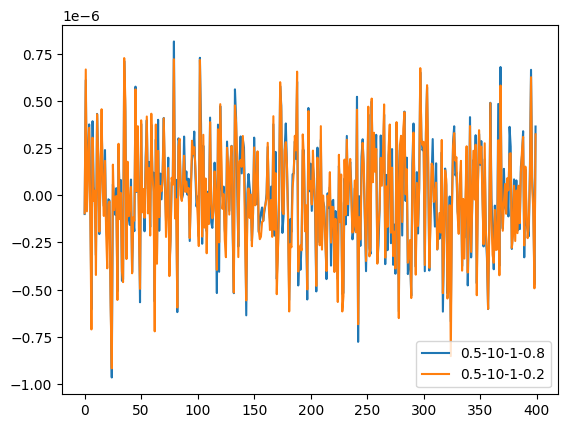

In [19]:
import numpy as np

tmp1 = np.load('behavior_weights_sub04_ses1_run1_task0.5_bold10_beta1_rho0.8.npy')
# tmp2 = np.load('behavior_weights_sub04_ses1_run1_task0.5_bold10_beta1_rho0.2.npy')
# tmp2 = np.load('behavior_weights_sub04_ses1_run1_task1_bold0.5_beta10_rho0.8.npy')
# tmp3 = np.load('behavior_weights_sub04_ses1_run1_task10_bold0.5_beta1_rho0.8.npy')

import matplotlib.pyplot as plt
idx = np.arange(10, 200000, 500)
plt.figure()
plt.plot(tmp1[idx], label="0.5-10-1-0.8")
plt.plot(tmp2[idx], label="0.5-10-1-0.2")
# plt.plot(tmp3[:300], label="10-0.5-1-0.8")
plt.legend()
plt.show()

In [20]:
idx

array([    10,    510,   1010,   1510,   2010,   2510,   3010,   3510,
         4010,   4510,   5010,   5510,   6010,   6510,   7010,   7510,
         8010,   8510,   9010,   9510,  10010,  10510,  11010,  11510,
        12010,  12510,  13010,  13510,  14010,  14510,  15010,  15510,
        16010,  16510,  17010,  17510,  18010,  18510,  19010,  19510,
        20010,  20510,  21010,  21510,  22010,  22510,  23010,  23510,
        24010,  24510,  25010,  25510,  26010,  26510,  27010,  27510,
        28010,  28510,  29010,  29510,  30010,  30510,  31010,  31510,
        32010,  32510,  33010,  33510,  34010,  34510,  35010,  35510,
        36010,  36510,  37010,  37510,  38010,  38510,  39010,  39510,
        40010,  40510,  41010,  41510,  42010,  42510,  43010,  43510,
        44010,  44510,  45010,  45510,  46010,  46510,  47010,  47510,
        48010,  48510,  49010,  49510,  50010,  50510,  51010,  51510,
        52010,  52510,  53010,  53510,  54010,  54510,  55010,  55510,
      

In [17]:
tmp1.shape

(235767,)

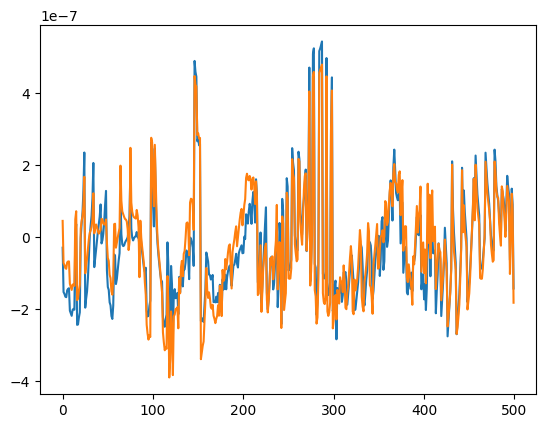

In [13]:
import numpy as np

tmp1 = np.load('behavior_weights_sub04_ses1_run1_task0_bold0_beta0_rho0.8.npy')
tmp2 = np.load('behavior_weights_sub04_ses1_run1_task0_bold0_beta0.5_rho0.8.npy')
tmp3 = np.load('behavior_weights_sub04_ses1_run1_task0_bold0.5_beta0_rho0.8.npy')
# tmp4 = np.load('behavior_weights_sub04_ses1_run1_task0.5_bold0_beta0.5_rho0.8.npy')
# tmp5 = np.load('behavior_weights_sub04_ses1_run1_task0.5_bold0.5_beta5_rho0.8.npy')


import matplotlib.pyplot as plt
plt.figure()
plt.plot(tmp1[:500])
plt.plot(tmp2[:500])
# plt.plot(tmp3[:500])
# plt.plot(tmp4[:300])
# plt.plot(tmp5[:300])
plt.show()